In [116]:
# Imports
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [117]:
def build_dpg(A):
    # Diagonal degree matrix of A
    D = np.diag(np.sum(A, axis=0))

    # Transition probability matrix from scaling all adjacencies with 1/degree
    P = np.matmul(np.linalg.inv(D), A)

    # Create networkx graph from adjacency matrix
    G = nx.from_numpy_matrix(A, parallel_edges=True, create_using=nx.MultiGraph())

    return D, P, G

In [118]:
def calculate_pi(P):
    # approximate stationary distribution of Markov Chain
    return [round(x, 3) for x in list(np.linalg.matrix_power(P, 10000)[0])]

In [119]:
def graph_rw_sim(nsim, n, v0, P):
    # nsim different random walks of length n on G
    all_walks = []
    ps = P.shape[0]
    
    for _ in range(nsim):
        walk = np.zeros(n+1)
        walk[0] = v0

        current = v0-1
        for k in range(1, n+1):
            vk = np.random.choice(range(ps), 1, p=P[current])
            current = vk[0]
            walk[k] = current+1
    
        all_walks.append(walk)

    simulation_data = pd.DataFrame(all_walks).T
    return(simulation_data)

In [120]:
def plot_graph_rw_sim(data):
    plt.figure(figsize=(5, 5))
    plt.plot(data)
    plt.show()

In [121]:
def graph_rw_cover_time_sim(nsim, v0, P, G):
    # nsim cover times for random walk on G
    node_set = set(sorted(G.nodes()))
    all_cover_times = []
    ps = P.shape[0]

    for _ in range(nsim):
        current = v0-1
        done = False
        visited = [v0]
        k = 0
        while not done:
            vk = np.random.choice(range(ps), 1, p=P[current])
            current = vk[0]
            visited.append(current+1)

            if(node_set == set(sorted(visited))):
                done = True
            else:
                k+=1
    
        all_cover_times.append(k)
    return(all_cover_times)

In [122]:
def expected_cover_time_mc(data):
    # expected cover time based on Monte Carlo
    return np.mean(data)

In [123]:
def main():
    # Good Will Hunting problem adjacency matrix
    A = np.array([[0, 1, 0, 1], #1
                [1, 0, 2, 1], #2
                [0, 2, 0, 0], #3
                [1, 1, 0, 0]]) #4
    
    D, P, G = build_dpg(A)
    
    # Relabel vertices in accordance with paper
    mapping = {3:1, 0:4, 1:2, 2:3}
    G = nx.relabel_nodes(G, mapping)

    # Plot
    pos = nx.spring_layout(G)
    figure, axes = plt.subplots(2, 2, figsize=(10, 5))

    for i, ax in enumerate(axes.flatten()):
        nx.draw_networkx(G, pos=pos, font_size=16, node_color='blue', font_color='white', ax=ax)
        nx.draw_networkx(G.subgraph(i+1), pos=pos, font_size=16, node_color='red', font_color='green', ax=ax)

    # Simulate
    v0 = np.random.choice(sorted(G.nodes()), p=[.25, .25, .25, .25])
    v0_pi = np.random.choice(sorted(G.nodes()), p=calculate_pi(P))

    NWALKS = 1
    WALKLEN = 60
    data = graph_rw_sim(NWALKS, WALKLEN, v0, P)
    plot_graph_rw_sim(data)

    NSIM=1000
    cover_time_data = graph_rw_cover_time_sim(NSIM, v0, P, G)
    cover_time_data_pi = graph_rw_cover_time_sim(NSIM, v0_pi, P, G)
    print("Expected cover time (random uniform start) is: %.2f" % expected_cover_time_mc(cover_time_data))
    print("Expected cover time (random stationary start) is: %.2f" % expected_cover_time_mc(cover_time_data_pi))

    # More simulations with random graphs
    G_complete = nx.complete_graph(10)
    G_lollipop = nx.lollipop_graph(5, 5)
    G_star = nx.star_graph(9)
    G_tree = nx.random_tree(10)
    G_regular = nx.random_regular_graph(5, 10)

    all_graphs = {"Complete":G_complete, "Lollipop":G_lollipop, "Star":G_star, "Tree":G_tree, "Regular":G_regular}
    for key in all_graphs.keys():
        all_graphs[key] = nx.convert_node_labels_to_integers(all_graphs[key], 1)
        
        A_rand = np.array(nx.adjacency_matrix(all_graphs[key]).todense())
        D_rand, P_rand, G_rand = build_dpg(A_rand)
        v0_rand = 1
        print("Expected cover time (", key, ") is: %.2f" % expected_cover_time_mc(graph_rw_cover_time_sim(NSIM, v0_rand, P_rand, all_graphs[key])))

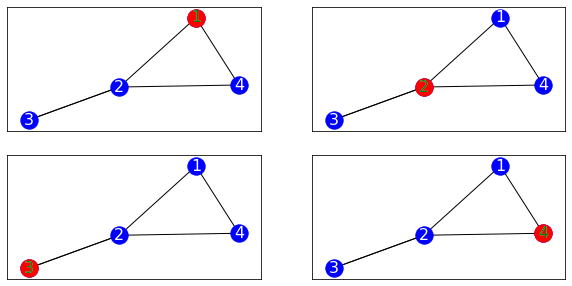

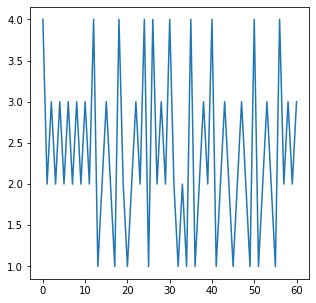

Expected cover time (random uniform start) is: 6.54
Expected cover time (random stationary start) is: 7.67
Expected cover time ( Complete ) is: 24.11
Expected cover time ( Lollipop ) is: 137.38
Expected cover time ( Star ) is: 48.03
Expected cover time ( Tree ) is: 77.46
Expected cover time ( Regular ) is: 26.89


In [124]:
if __name__ == "__main__":
    main()